In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import torchtext
import datasets
import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import evaluate

C:\Users\KK\.conda\envs\py39_torch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
# Загружаем датасет
dataset = datasets.load_dataset("cointegrated/nli-rus-translated-v2021")
# dataset = datasets.load_dataset("bentrevett/multi30k")

In [5]:
# Изменить dev -> validation
dataset['validation'] = dataset.pop('dev')

# Изменить premise -> en
for subset_name in dataset.keys():
    dataset[subset_name] = dataset[subset_name].rename_column('premise', 'en')

# Изменить premise_ru -> ru
for subset_name in dataset.keys():
    dataset[subset_name] = dataset[subset_name].rename_column('premise_ru', 'ru')

In [6]:
# Убираем все столбцы кроме 'en' и 'ru' для каждого раздела (train, test, validation)
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(['hypothesis', 'label', 'source', 'split', 'hypothesis_ru', 'reverse_entailment_score', 'len_ratio', 'idx'])

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'ru'],
        num_rows: 1756548
    })
    test: Dataset({
        features: ['en', 'ru'],
        num_rows: 34615
    })
    validation: Dataset({
        features: ['en', 'ru'],
        num_rows: 106557
    })
})

In [8]:
dataset["train"][0]

{'en': 'I learned how to play the board game.',
 'ru': 'Я научился играть в настольную игру.'}

In [9]:
train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)

# Ограничение размеров
train_data = train_data.shuffle(seed=42).select(range(40000))
valid_data = valid_data.shuffle(seed=42).select(range(1000))
test_data = test_data.shuffle(seed=42).select(range(1000))

In [10]:
# Создание нового DatasetDict с обрезанными частями
dataset = datasets.DatasetDict({
    'train': train_data,
    'validation': valid_data,
    'test': test_data
})

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'ru'],
        num_rows: 40000
    })
    validation: Dataset({
        features: ['en', 'ru'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['en', 'ru'],
        num_rows: 1000
    })
})

In [12]:
train_data[0]

{'en': 'Human genome draft sequence offers clues to health.',
 'ru': 'Последовательность набросков генома человека дает ключ к пониманию здоровья.'}

In [13]:
#!python -m spacy download en_core_web_sm
#!python -m spacy download ru_core_news_sm

In [14]:
en_nlp = spacy.load("en_core_web_sm")
ru_nlp = spacy.load("ru_core_news_sm")

In [15]:
def tokenize_example(example, en_nlp, ru_nlp, max_length, lower, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    ru_tokens = [token.text for token in ru_nlp.tokenizer(example["ru"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        ru_tokens = [token.lower() for token in ru_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    ru_tokens = [sos_token] + ru_tokens + [eos_token]
    return {"en_tokens": en_tokens, "ru_tokens": ru_tokens}

In [16]:
max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "ru_nlp": ru_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

In [17]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

ru_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["ru_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [18]:
assert en_vocab[unk_token] == ru_vocab[unk_token]
assert en_vocab[pad_token] == ru_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

In [19]:
en_vocab.set_default_index(unk_index)
ru_vocab.set_default_index(unk_index)

In [20]:
def numericalize_example(example, en_vocab, ru_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    ru_ids = ru_vocab.lookup_indices(example["ru_tokens"])
    return {"en_ids": en_ids, "ru_ids": ru_ids}

In [21]:
fn_kwargs = {"en_vocab": en_vocab, "ru_vocab": ru_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

In [22]:
data_type = "torch"
format_columns = ["en_ids", "ru_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

In [23]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_ru_ids = [example["ru_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_ru_ids = nn.utils.rnn.pad_sequence(batch_ru_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "ru_ids": batch_ru_ids,
        }
        return batch

    return collate_fn

In [24]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [25]:
batch_size = 12

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [26]:
class Encoder(nn.Module):
    def __init__(
        self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout
    ):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        outputs, hidden = self.rnn(embedded)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        # outputs are always from the last layer
        # hidden [-2, :, : ] is the last of the forwards RNN
        # hidden [-1, :, : ] is the last of the backwards RNN
        # initial decoder hidden is final hidden state of the forwards and backwards
        # encoder RNNs fed through a linear layer
        hidden = torch.tanh(
            self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        )
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        return outputs, hidden

In [27]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]
        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # hidden = [batch size, src length, decoder hidden dim]
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy = [batch size, src length, decoder hidden dim]
        attention = self.v_fc(energy).squeeze(2)
        # attention = [batch size, src length]
        return torch.softmax(attention, dim=1)

In [28]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        dropout,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input = [batch size]
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        a = a.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        # weighted = [batch size, 1, encoder hidden dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, encoder hidden dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim=2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + embedding dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq length, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        # prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [29]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

In [30]:
input_dim = len(ru_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention,
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [31]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(49814, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(27422, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=27422, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 75,373,342 trainable parameters


In [33]:
optimizer = optim.Adam(model.parameters())

In [34]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [179]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        print(f"{i}/{len(data_loader)}")
        src = batch["ru_ids"].to(device)
        trg = batch["en_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [36]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["ru_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [37]:
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "translator_ru_en.pt")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Done: 0/3334
Done: 1/3334
Done: 2/3334
Done: 3/3334
Done: 4/3334
Done: 5/3334
Done: 6/3334
Done: 7/3334
Done: 8/3334
Done: 9/3334
Done: 10/3334
Done: 11/3334
Done: 12/3334
Done: 13/3334
Done: 14/3334
Done: 15/3334
Done: 16/3334
Done: 17/3334
Done: 18/3334
Done: 19/3334
Done: 20/3334
Done: 21/3334
Done: 22/3334
Done: 23/3334
Done: 24/3334
Done: 25/3334
Done: 26/3334
Done: 27/3334
Done: 28/3334
Done: 29/3334
Done: 30/3334
Done: 31/3334
Done: 32/3334
Done: 33/3334
Done: 34/3334
Done: 35/3334
Done: 36/3334
Done: 37/3334
Done: 38/3334
Done: 39/3334
Done: 40/3334
Done: 41/3334
Done: 42/3334
Done: 43/3334
Done: 44/3334
Done: 45/3334
Done: 46/3334
Done: 47/3334
Done: 48/3334
Done: 49/3334
Done: 50/3334
Done: 51/3334
Done: 52/3334
Done: 53/3334
Done: 54/3334
Done: 55/3334
Done: 56/3334
Done: 57/3334
Done: 58/3334
Done: 59/3334
Done: 60/3334
Done: 61/3334
Done: 62/3334
Done: 63/3334
Done: 64/3334
Done: 65/3334
Done: 66/3334
Done: 67/3334
Done: 68/3334
Done: 69/3334
Done: 70/3334
Done: 71/3334
Do

 10%|███████▌                                                                    | 1/10 [2:41:42<24:15:20, 9702.22s/it]

	Train Loss:   5.777 | Train PPL: 322.712
	Valid Loss:   5.538 | Valid PPL: 254.078
Done: 0/3334
Done: 1/3334
Done: 2/3334
Done: 3/3334
Done: 4/3334
Done: 5/3334
Done: 6/3334
Done: 7/3334
Done: 8/3334
Done: 9/3334
Done: 10/3334
Done: 11/3334
Done: 12/3334
Done: 13/3334
Done: 14/3334
Done: 15/3334


 10%|███████▌                                                                    | 1/10 [2:42:19<24:20:54, 9739.41s/it]


KeyboardInterrupt: 

In [37]:
model.load_state_dict(torch.load("translator_ru_en.pt"))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 5.625 | Test PPL: 277.184 |


In [38]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    ru_nlp,
    en_vocab,
    ru_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            ru_tokens = [token.text for token in ru_nlp.tokenizer(sentence)]
        else:
            ru_tokens = [token for token in sentence]
        if lower:
            ru_tokens = [token.lower() for token in ru_tokens]
        rue_tokens = [sos_token] + ru_tokens + [eos_token]
        ids = ru_vocab.lookup_indices(ru_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(
                inputs_tensor, hidden, encoder_outputs
            )
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        en_tokens = en_vocab.lookup_tokens(inputs)
    return en_tokens, ru_tokens, attentions[: len(en_tokens) - 1]

In [39]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(10, 10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

In [162]:
sentence = test_data[335]["ru"]
expected_translation = test_data[335]["en"]

sentence, expected_translation

('Здесь нет дресс - кода .', 'There is no dress code .')

In [163]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    ru_nlp,
    en_vocab,
    ru_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [164]:
translation

['<sos>',
 'there',
 'are',
 'no',
 'longer',
 'there',
 'are',
 'no',
 'longer',
 '.',
 '.',
 'there',
 'is',
 'no',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.']

In [165]:
sentence

'Здесь нет дресс - кода .'

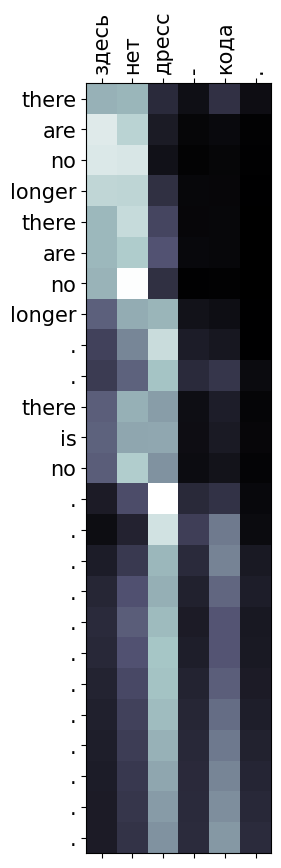

In [166]:
plot_attention(sentence_tokens, translation, attention)

In [167]:
sentence = "Как у тебя дела?"

In [168]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    ru_nlp,
    en_vocab,
    ru_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [169]:
translation

['<sos>',
 'how',
 'many',
 'you',
 'are',
 'how',
 'many',
 'you',
 'you',
 '?',
 'you',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?',
 '?']

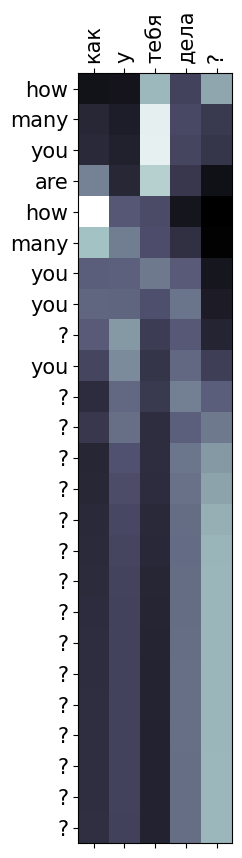

In [170]:
plot_attention(sentence_tokens, translation, attention)

In [171]:
translations = [
    translate_sentence(
        example["ru"],
        model,
        en_nlp,
        ru_nlp,
        en_vocab,
        ru_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )[0]
    for example in tqdm.tqdm(test_data)
]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.46it/s]


In [172]:
bleu = evaluate.load("bleu")

In [173]:
predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_data]

In [174]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [175]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [176]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

In [177]:
results

{'bleu': 0.019195445034269495,
 'precisions': [0.27477010054746487,
  0.0649422941329276,
  0.01903880988168189,
  0.006894616587164789],
 'brevity_penalty': 0.4906665267352452,
 'length_ratio': 0.584115372557216,
 'translation_length': 27947,
 'reference_length': 47845}

In [178]:
!pip list

Package                      Version
---------------------------- ------------------
absl-py                      2.1.0
aiohttp                      3.9.3
aiosignal                    1.3.1
annotated-types              0.6.0
anyio                        4.2.0
appdirs                      1.4.4
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
async-lru                    2.0.4
async-timeout                4.0.3
attrs                        23.1.0
Babel                        2.11.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       4.1.0
blis                         0.7.11
Brotli                       1.0.9
catalogue                    2.0.10
certifi                      2024.2.2
cffi                         1.16.0
chardet                      3.0.4
charset-normalizer           2.0.4
click                        8.1.7
cloudpathlib                 